In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
np.random.seed(42)

# Реализация алгоритмов

In [2]:
class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        if feature_subsample_size is None:
            feature_subsample_size = 1 / 3
        self.feature_subsample_size = feature_subsample_size
        self.trees = [DecisionTreeRegressor(max_depth=max_depth, **trees_parameters) for _ in range(n_estimators)]

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """

        if X_val is not None and y_val is not None:
            rmse = []

        self.features_num = []
        block_size = int(X.shape[0] * (1 - 1 / np.e))
        feature_size = int(X.shape[1] * self.feature_subsample_size)
        for i in range(self.n_estimators):
            objects = np.random.choice(X.shape[0], block_size, replace=False)
            features = np.random.choice(X.shape[1], feature_size, replace=False)
            self.features_num.append(features)
            self.trees[i].fit(X[objects][:, features], y[objects])

            if X_val is not None and y_val is not None:
                rmse.append(mean_squared_error(y_val, self.predict(X_val), squared=False))

        if X_val is not None and y_val is not None:
            return np.array(rmse)

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """

        answers = []
        for i in range(self.n_estimators):
            answers.append(self.trees[i].predict(X[:, self.features_num[i]]))

        return np.mean(np.array(answers), axis=0)


class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        if feature_subsample_size is None:
            feature_subsample_size = 1 / 3
        self.feature_subsample_size = feature_subsample_size
        self.trees = [DecisionTreeRegressor(max_depth=max_depth, **trees_parameters) for _ in range(n_estimators)]

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """

        if X_val is not None and y_val is not None:
            rmse = []

        self.features_num = []
        self.coefs= []
        block_size = int(X.shape[0] * (1 - 1 / np.e))
        feature_size = int(X.shape[1] * self.feature_subsample_size)
        a = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            objects = np.random.choice(X.shape[0], block_size, replace=False)
            features = np.random.choice(X.shape[1], feature_size, replace=False)
            self.features_num.append(features)
            grad = 2 * (y - a)
            self.trees[i].fit(X[objects][:, features], grad[objects])
            y_pred = self.trees[i].predict(X[:, features])
            loss = lambda alpha: np.mean(((a + alpha * self.learning_rate * y_pred) - y) ** 2)
            best_alpha = minimize_scalar(loss)
            self.coefs.append(best_alpha.x * self.learning_rate)
            a += self.coefs[-1] * y_pred

            if X_val is not None and y_val is not None:
                rmse.append(mean_squared_error(y_val, self.predict(X_val), squared=False))

        if X_val is not None and y_val is not None:
            return np.array(rmse)

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """

        answers = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            answers += self.coefs[i] * self.trees[i].predict(X[:, self.features_num[i]])

        return answers


# Предобработка данных

In [3]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/5n1OhvVdzL_TKw) -o train.csv


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2456k  100 2456k    0     0  2537k      0 --:--:-- --:--:-- --:--:-- 8564k


In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
df = df.drop(['id'], axis=1)

In [8]:
df['date'].head(10)

0    20141013T000000
1    20141209T000000
2    20150225T000000
3    20141209T000000
4    20150218T000000
5    20140512T000000
6    20140627T000000
7    20150115T000000
8    20150415T000000
9    20150312T000000
Name: date, dtype: object

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['yr_built'].head(10)

0    1955
1    1951
2    1933
3    1965
4    1987
5    2001
6    1995
7    1963
8    1960
9    2003
Name: yr_built, dtype: int64

In [11]:
df['yr_renovated'].head(10)

0       0
1    1991
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
Name: yr_renovated, dtype: int64

In [12]:
df.loc[df['yr_renovated'] == 0, ['yr_renovated']] = df['yr_built']

In [13]:
df['yr_built'] = df['date'].dt.year - df['yr_built']
df['yr_renovated'] = df['date'].dt.year - df['yr_renovated']

In [14]:
df['date'] = df['date'].dt.day_of_year

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  int32  
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [16]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
y_train = X_train['price'].copy()
X_train = X_train.drop('price', axis=1)
y_test = X_test['price'].copy()
X_test = X_test.drop('price', axis=1)

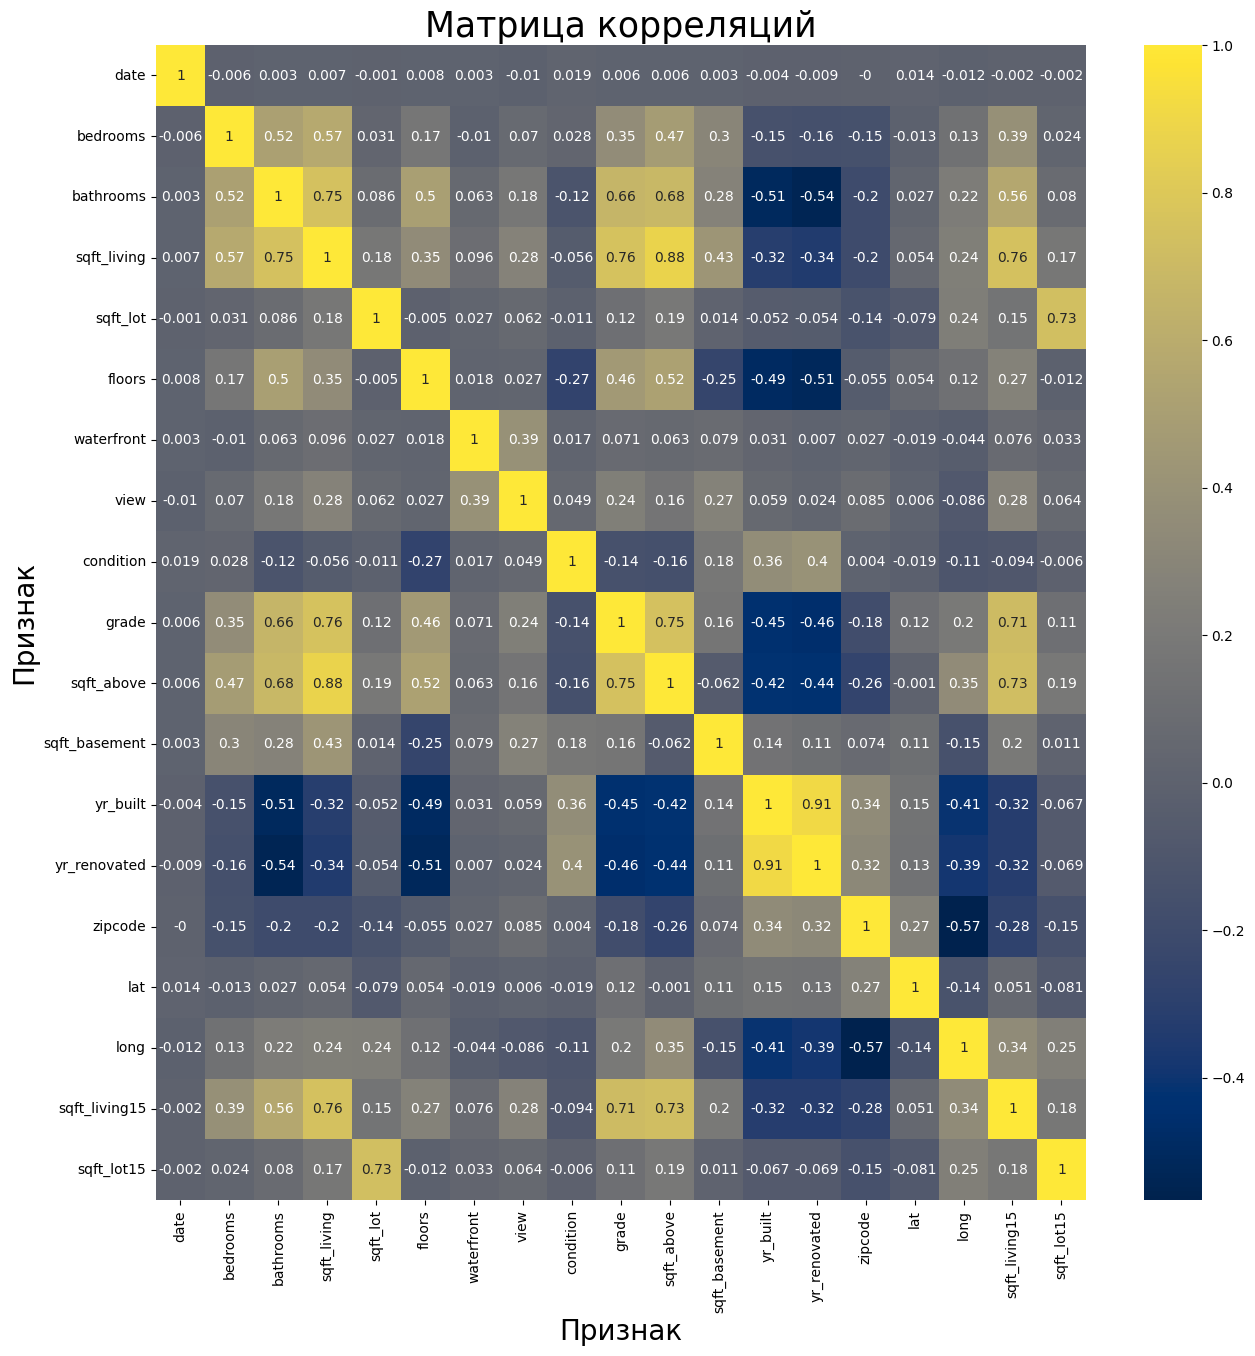

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(round(X_train.corr(), 3), annot=True, cmap='cividis')
plt.title("Матрица корреляций", fontsize=25)
plt.xlabel("Признак", fontsize=20)
plt.ylabel("Признак", fontsize=20)
plt.savefig("matr.svg", format='svg')
plt.show()

In [18]:
X_train = X_train.drop(['sqft_above', 'yr_built'], axis=1)
X_test = X_test.drop(['sqft_above', 'yr_built'], axis=1)

In [19]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Анализ случайного леса

Количество деревьев

In [87]:
n_trees = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
metrics = []
times = []

for n in n_trees:
    model = RandomForestMSE(n_estimators=n, max_depth=20)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

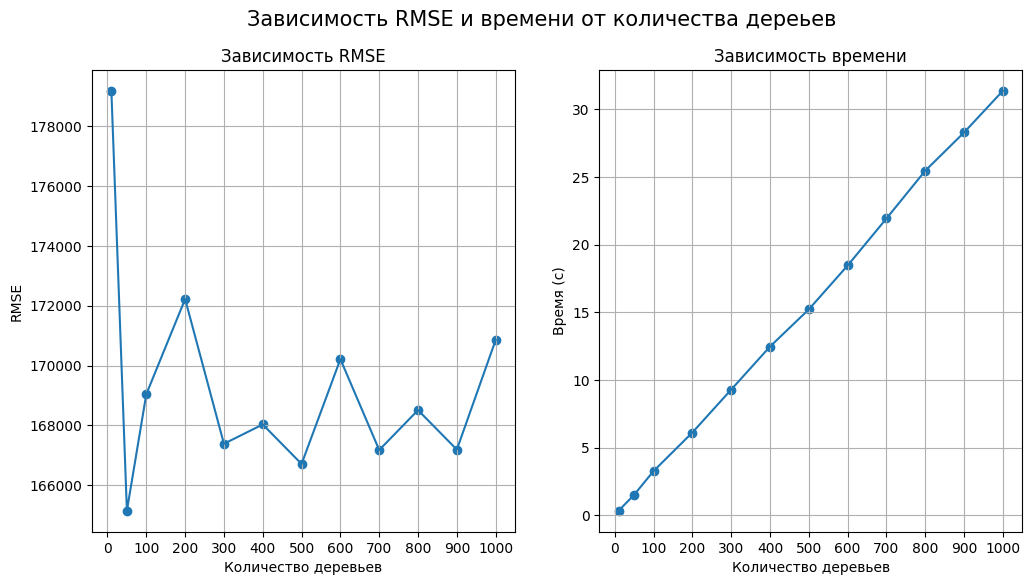

In [88]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от количества дереьев", fontsize=15)

plt.subplot(121)
plt.plot(n_trees, metrics)
plt.scatter(n_trees, metrics)
plt.grid()
plt.xticks(np.arange(0, 1100, 100))
plt.title("Зависимость RMSE")
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(n_trees, times)
plt.scatter(n_trees, times)
plt.grid()
plt.xticks(np.arange(0, 1100, 100))
plt.title("Зависимость времени")
plt.xlabel("Количество деревьев")
plt.ylabel("Время (с)")

plt.savefig("forest_n.svg", format='svg')
plt.show()

Размерность пространства

In [89]:
dim = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metrics = []
times = []

for d in dim:
    model = RandomForestMSE(n_estimators=500, max_depth=10, feature_subsample_size=d)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

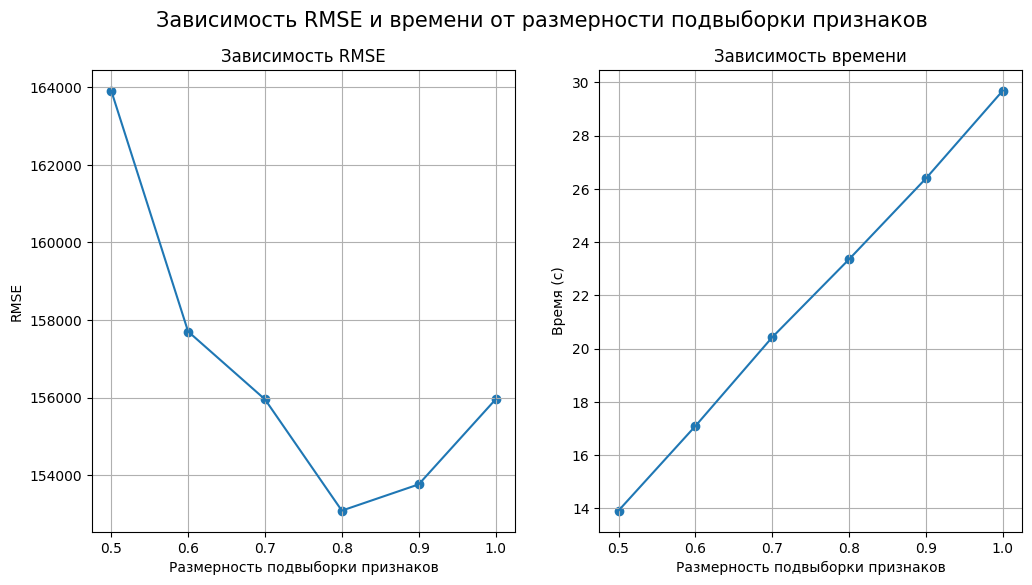

In [90]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от размерности подвыборки признаков", fontsize=15)

plt.subplot(121)
plt.plot(dim, metrics)
plt.scatter(dim, metrics)
plt.grid()
plt.title("Зависимость RMSE")
plt.xlabel("Размерность подвыборки признаков")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(dim, times)
plt.scatter(dim, times)
plt.grid()
plt.title("Зависимость времени")
plt.xlabel("Размерность подвыборки признаков")
plt.ylabel("Время (с)")

plt.savefig("forest_dim.svg", format='svg')
plt.show()

Глубина дерева

In [91]:
depth = [3, 5, 10, 25, None]
metrics = []
times = []

for d in depth:
    model = RandomForestMSE(n_estimators=500, max_depth=d, feature_subsample_size=0.9)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

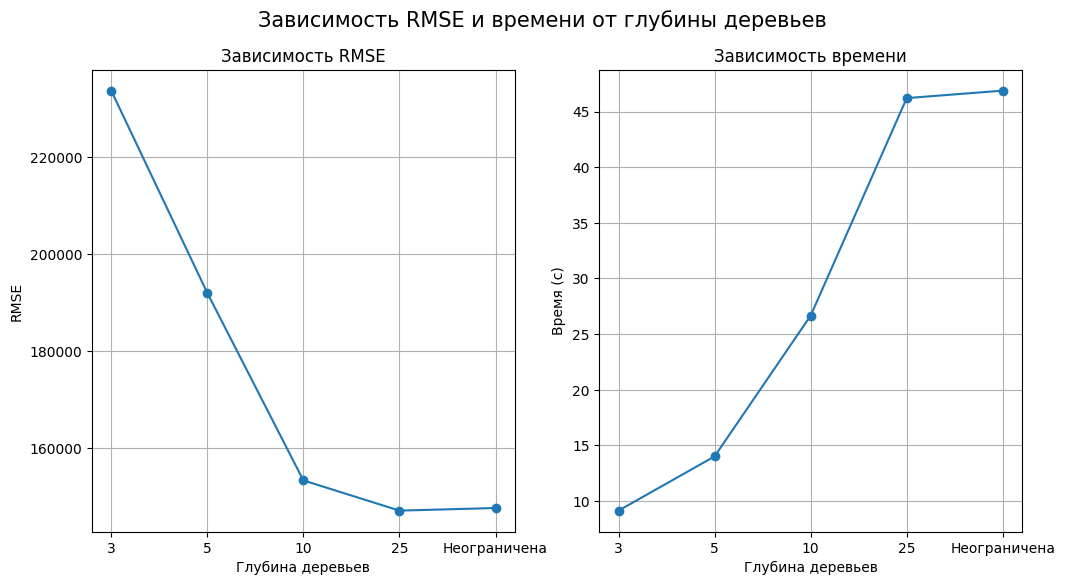

In [92]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от глубины деревьев", fontsize=15)

depth_p = [3, 5, 10, 25, 'Неограничена']
plt.subplot(121)
plt.plot(depth_p, metrics, marker='o')
plt.grid()
plt.title("Зависимость RMSE")
plt.xlabel("Глубина деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(depth_p, times, marker='o')
plt.grid()
plt.title("Зависимость времени")
plt.xlabel("Глубина деревьев")
plt.ylabel("Время (с)")

plt.savefig("forest_depth.svg", format='svg')
plt.show()

# Анализ градиентного бустинга

Количество деревьев

In [20]:
n_trees = [10, 50, 100, 250, 500, 750, 1000, 1500, 2000]
metrics = []
times = []

for n in n_trees:
    model = GradientBoostingMSE(n_estimators=n, max_depth=6)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

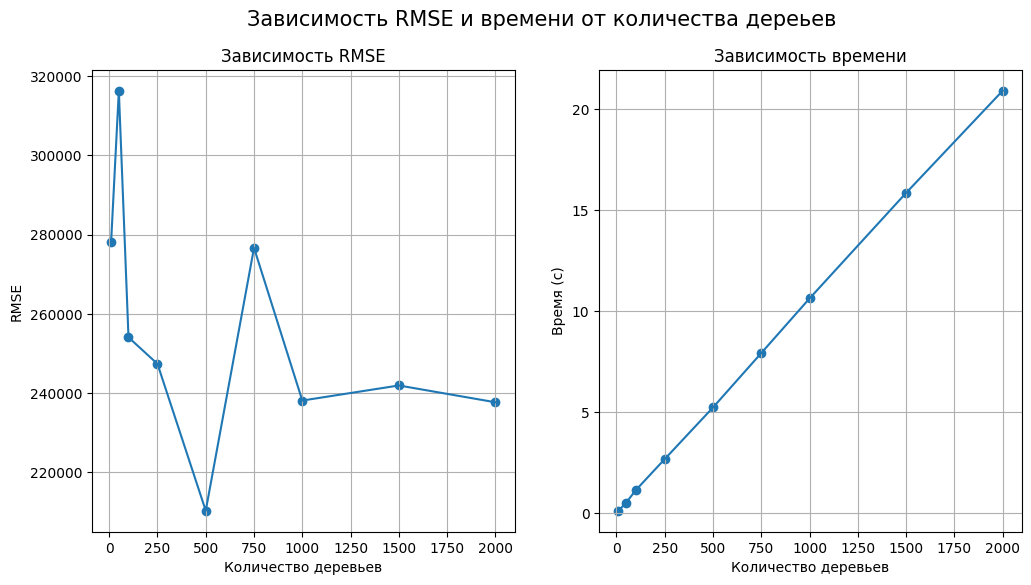

In [22]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от количества дереьев", fontsize=15)

plt.subplot(121)
plt.plot(n_trees, metrics)
plt.scatter(n_trees, metrics)
plt.grid()
plt.xticks(np.arange(0, 2250, 250))
plt.title("Зависимость RMSE")
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(n_trees, times)
plt.scatter(n_trees, times)
plt.grid()
plt.xticks(np.arange(0, 2250, 250))
plt.title("Зависимость времени")
plt.xlabel("Количество деревьев")
plt.ylabel("Время (с)")

plt.savefig("boost_n.svg", format='svg')
plt.show()

Размерность признаков

In [95]:
dim = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metrics = []
times = []

for d in dim:
    model = GradientBoostingMSE(n_estimators=100, max_depth=10, feature_subsample_size=d)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

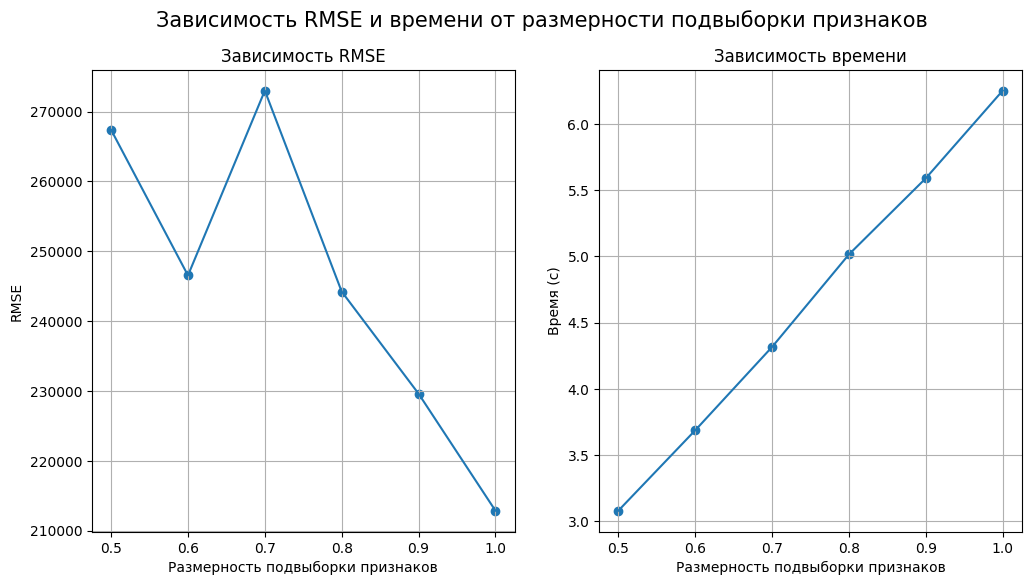

In [96]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от размерности подвыборки признаков", fontsize=15)

plt.subplot(121)
plt.plot(dim, metrics)
plt.scatter(dim, metrics)
plt.grid()
plt.title("Зависимость RMSE")
plt.xlabel("Размерность подвыборки признаков")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(dim, times)
plt.scatter(dim, times)
plt.grid()
plt.title("Зависимость времени")
plt.xlabel("Размерность подвыборки признаков")
plt.ylabel("Время (с)")

plt.savefig("boost_dim.svg", format='svg')
plt.show()

Глубина дерева

In [97]:
depth = [3, 5, 10, 20, 30, 40, None]
metrics = []
times = []

for d in depth:
    model = GradientBoostingMSE(n_estimators=100, max_depth=d)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

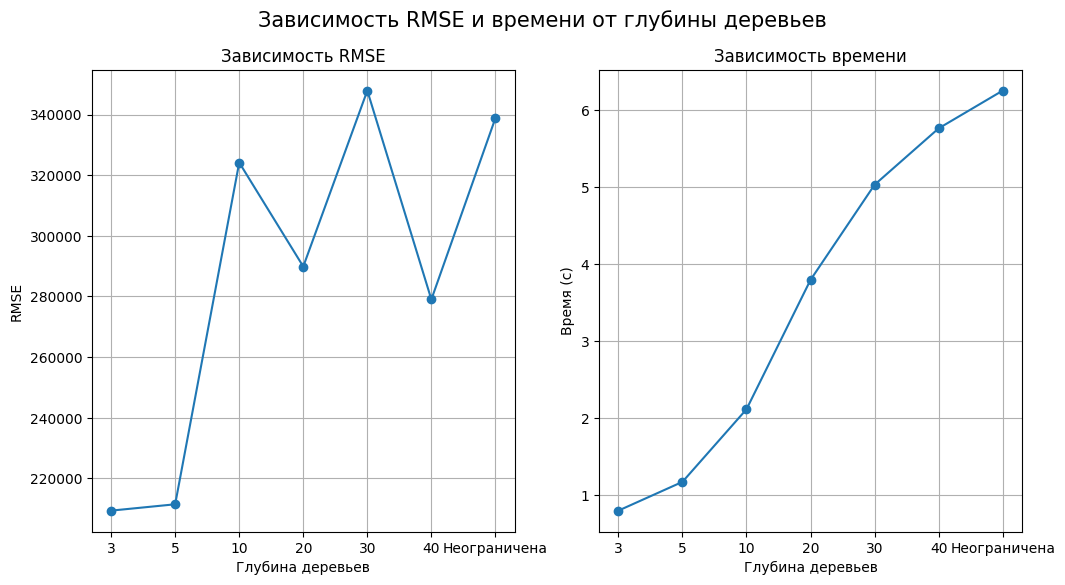

In [98]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от глубины деревьев", fontsize=15)

depth_p = [3, 5, 10, 20, 30, 40, 'Неограничена']
plt.subplot(121)
plt.plot(depth_p, metrics, marker='o')
plt.grid()
plt.title("Зависимость RMSE")
plt.xlabel("Глубина деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(depth_p, times, marker='o')
plt.grid()
plt.title("Зависимость времени")
plt.xlabel("Глубина деревьев")
plt.ylabel("Время (с)")

plt.savefig("boost_depth.svg", format='svg')
plt.show()

Шаг обучения

In [99]:
lr_list = np.logspace(-4, 0, 9)
metrics = []
times = []

for lr in lr_list:
    model = GradientBoostingMSE(n_estimators=100, max_depth=5, learning_rate=lr)
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    metrics.append(mean_squared_error(y_test, y_pred, squared=False))
    times.append(end - start)

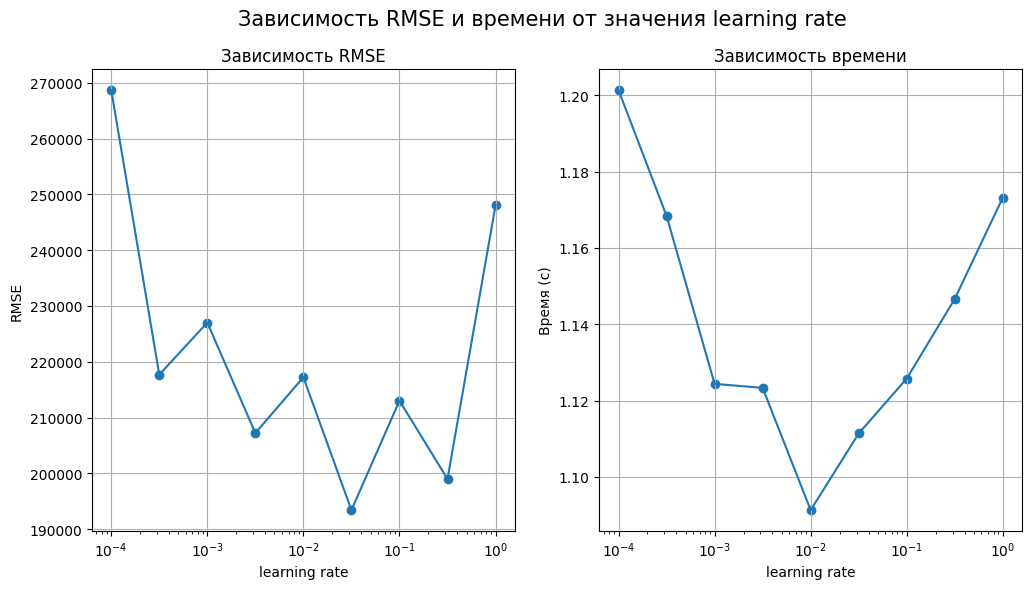

In [100]:
plt.figure(figsize=(12, 6))
plt.suptitle("Зависимость RMSE и времени от значения learning rate", fontsize=15)

plt.subplot(121)
plt.plot(lr_list, metrics)
plt.scatter(lr_list, metrics)
plt.grid()
plt.title("Зависимость RMSE")
plt.xlabel("learning rate")
plt.xscale('log')
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(lr_list, times)
plt.scatter(lr_list, times)
plt.grid()
plt.title("Зависимость времени")
plt.xlabel("learning rate")
plt.xscale('log')
plt.ylabel("Время (с)")

plt.savefig("boost_lr.svg", format='svg')
plt.show()